In [34]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import dask
import dask.dataframe as ddf
import numpy as np
from tqdm import tqdm

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
signal_df = pd.read_parquet("train/data/signal_data.parquet")
background_df = pd.read_parquet("train/data/background_data.parquet")#.compute(scheduler='threads')

In [4]:
signal_fatjets = signal_df['FatJets']
background_fatjets = background_df['FatJets']

keys = list(signal_fatjets[0][0].keys())

In [19]:
def extract(dframe, key):
    return dframe[0][key]

signal_key_vals = {}
for i in keys:
    signal_key_vals[i] = signal_fatjets.apply(lambda x: extract(x, i)).values.tolist()
    
background_key_vals = {}
for i in keys:
    background_key_vals[i] = background_fatjets.apply(lambda x: extract(x, i)).values.tolist()

In [23]:
items = ['area', 'eta', 'mass','msoftdrop', 'n2b1', 'n3b1', 'phi', 'pt', 'isSignal']
items2 = ['msoftdrop', 'pt', 'isSignal']

In [21]:
signal_key_vals['isSignal'] = np.ones_like(signal_key_vals[items[0]])
background_key_vals['isSignal'] = np.zeros_like(background_key_vals[items[0]])

In [22]:
step_sig = pd.DataFrame.from_dict(signal_key_vals)
step_bkg = pd.DataFrame.from_dict(background_key_vals)

In [24]:
small_sig = step_sig[items]
small_bkg = step_bkg[items]

In [26]:
NDIM = len(items) - 1
df_all = pd.concat([small_sig, small_bkg])
dataset = df_all.values
X = dataset[:, 0:NDIM]
y = dataset[:, NDIM]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
X_train = torch.from_numpy(X_train).type(torch.float).to(device)
X_test = torch.from_numpy(X_test).type(torch.float).to(device)
y_train = torch.from_numpy(y_train).type(torch.float).to(device)
y_test = torch.from_numpy(y_test).type(torch.float).to(device)

In [75]:
# Build our model.
import torch

class NeuralNetwork(nn.Module):
    def __init__(self, width=256):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, 1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)

loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [76]:
losses, test_losses = [], []

for t in tqdm(range(350)):

    model.train()
    y_pred = model(X_train)
    y_b = y_train.view(-1,1)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_b)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    with torch.inference_mode():
        
        model.eval()
        test_pred = model(X_test)

        test_label = y_test.view_as(test_pred)
        test_loss = loss_fn(test_pred, test_label)

    losses.append(loss.item())
    test_losses.append(test_loss.item())

100%|██████████| 350/350 [00:00<00:00, 370.77it/s]


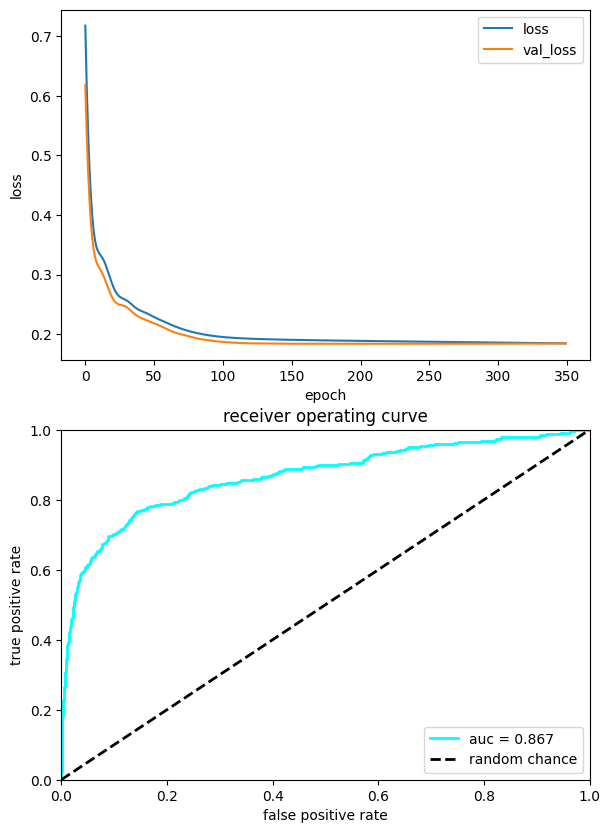

In [77]:
with torch.inference_mode():
    # plot loss vs epoch
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(2, 2, 1)
    ax.plot(losses, label="loss")
    ax.plot(test_losses, label="val_loss")
    ax.legend(loc="upper right")
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")

    # Plot ROC
    X_test_in = X_test
    Y_predict = model(X_test_in)
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(y_test.cpu(), Y_predict.cpu())
    roc_auc = auc(fpr, tpr)
    ax = plt.subplot(2, 2, 3)
    ax.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k", label="random chance")
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel("false positive rate")
    ax.set_ylabel("true positive rate")
    ax.set_title("receiver operating curve")
    ax.legend(loc="lower right")
    plt.show()